In [ ]:
# Install the 'segmentation-models-pytorch' library using pip
!pip install segmentation-models-pytorch

In [ ]:
# Install required libraries using pip
!pip install torch torchvision rasterio albumentations matplotlib

## **[1] Importación de Librerías**

In [ ]:
# ===============================
# 1️⃣ Core Python Libraries
# ===============================
import os  # For file and directory manipulation
import warnings
import numpy as np  # For numerical operations, especially on arrays
from google.colab import files
from google.colab import drive
from tqdm import tqdm
import random
from statistics import mean, stdev

# ===============================
# 2️⃣ Visualization
# ===============================
import matplotlib.pyplot as plt  # For plotting images and graphs
import cv2

# ===============================
# 3️⃣ PyTorch Libraries
# ===============================
import torch  # Main PyTorch library for tensor computations
import torch.nn as nn  # Sub-library for neural networks and layers
import torch.optim as optim  # Sub-library for optimization algorithms
from torch.utils.data import Dataset, DataLoader  # For creating custom datasets and loading batches
from torch.utils.data import random_split  # Ensure this is imported at the top
from torch.utils.data import Subset

# ===============================
# 4️⃣ Computer Vision & Geospatial
# ===============================
import rasterio  # For reading and writing raster (geospatial) data formats like GeoTIFF
from torchvision import transforms  # For image transformations (preprocessing)

# ===============================
# 5️⃣ Data Augmentation
# ===============================
import albumentations as A  # For applying data augmentation techniques
from albumentations.pytorch import ToTensorV2  # Converts augmented data into PyTorch tensors

# ===============================
# 6️⃣ Segmentation Models
# ===============================
import segmentation_models_pytorch as smp  # Pretrained segmentation models and utilities (UNet, DeepLabV3+, etc.)

# ===============================
# 7️⃣ Scikit-Learn Utilities
# ===============================
from sklearn.model_selection import KFold  # For performing K-Fold cross-validation

# ===============================
# 🔒 Reproducibility Settings
# ===============================
warnings.filterwarnings("ignore")  # Ignore all warning messages
random_seed = 3301

# Set the seed for generating random numbers in PyTorch (CPU)
torch.manual_seed(random_seed)
# Set the seed for generating random numbers in PyTorch (GPU) across all devices
torch.cuda.manual_seed_all(random_seed)
# Set the seed for generating random numbers in NumPy
np.random.seed(random_seed)
# Set the seed for generating random numbers in the Python random module
random.seed(random_seed)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## **[2] Creación de Conjunto de Datos**

In [ ]:
class dataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        """
        Args:
            image_dir (str): Directory path containing GeoTIFF images.
            mask_dir (str): Directory path containing corresponding PNG masks.
            transform (callable, optional): Albumentations transform to apply to image-mask pairs.
        """
        self.image_dir = image_dir  # Path to the folder with input images
        self.mask_dir = mask_dir  # Path to the folder with ground truth masks

        # List all .tif image files and .png mask files, sorted for consistent pairing
        self.image_files = sorted([file for file in os.listdir(image_dir) if file.endswith(".tif")])
        self.mask_files = sorted([file for file in os.listdir(mask_dir) if file.endswith(".png")])

        self.transform = transform  # Albumentations transform for data augmentation

    def __len__(self):
        """Returns the total number of samples"""
        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Loads and returns a single image-mask pair at the specified index.
        Applies transformations if provided.
        """
        # Load 4-band GeoTIFF image
        img_path = os.path.join(self.image_dir, self.image_files[idx])  # Full path to the image file
        with rasterio.open(img_path) as src:
            img = src.read().astype(np.float32)  # Read all bands → shape: (4, H, W), convert to float32

        img = np.transpose(img, (1, 2, 0))  # Rearrange to shape: (H, W, 4) for compatibility with Albumentations

        # Load corresponding mask
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])  # Full path to the mask file
        mask = plt.imread(mask_path)  # Read the mask (may be grayscale or RGB)

        if mask.ndim == 3:
            mask = mask[..., 0].astype(np.float32)  # Convert RGB mask to grayscale by taking the first channel

        # Apply transformation
        if self.transform:
            augmented = self.transform(image=img, mask=mask)  # Apply Albumentations transform
            img = augmented['image']  # Transformed image (as tensor)
            mask = augmented['mask'].unsqueeze(0) # Transformed mask (as tensor)
        else:
            # If no transform, convert image and mask to PyTorch tensors manually
            img = torch.from_numpy(np.transpose(img, (2, 0, 1))).float()  # (H, W, 4) → (4, H, W)
            mask = torch.from_numpy(mask).unsqueeze(0).float()  # Add channel dimension: (1, H, W)

        return img, mask  # Return image-mask pair

In [ ]:
# Define a set of data augmentation transforms using Albumentations
transform = A.Compose([
    A.HorizontalFlip(p=0.5),  # Randomly flip image and mask horizontally with 50% probability
    A.VerticalFlip(p=0.5),  # Randomly flip image and mask vertically with 50% probability
    A.RandomBrightnessContrast(p=0.3),
    ToTensorV2()  # Convert image and mask to PyTorch tensors
])

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create training dataset
data = dataset(
    image_dir = "/content/drive/MyDrive/tiles/image_01",  # Directory with GeoTIFF images
    mask_dir = "/content/drive/MyDrive/tiles/image_01/ground_truth",  # Directory with masks
    transform = transform  # Apply the augmentation pipeline
)

In [ ]:
print(f"Number of samples in dataset: {len(data)}")

Number of samples in dataset: 103


In [ ]:
# Calculate number of samples for training and CV (85%) and testing (15%)
train = int(0.85 * len(data))  # 85% for training
test = len(data) - train  # Remaining 15% for testing

In [ ]:
# Split the full dataset into train, validation, and test sets
train, test = random_split(
    data,  # The complete dataset to be split
    [train, test],  # Sizes for each split
    generator=torch.Generator().manual_seed(random_seed)  # Ensures reproducible splits
)

In [ ]:
# Create a DataLoader for the test set
test_loader = DataLoader(
    test,           # Test dataset
    batch_size = 8,  # Number of samples per batch
    shuffle =  False     # No shuffling during test to maintain consistent order
)

## **[3] U-Net para Segmentación**

### **[1] Definición de Modelo**

In [ ]:
# Choose architecture and encoder for the segmentation model
u_net = smp.Unet(
    encoder_name="resnet34",        # Backbone architecture (ResNet34)
    encoder_weights="imagenet",     # Use pretrained weights from ImageNet
    in_channels=4,                  # Input has 4 channels (R, G, B, NIR)
    classes=1,                      # Output has 1 channel for binary segmentation
    activation=None
).to(device)  # Move model to the specified device

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [ ]:
# Freeze the encoder part of the U-Net model by setting `requires_grad = False` for all its parameters.
# This means the encoder parameters will not be updated during backpropagation,
# and only the decoder parameters (if any) will be trained.
for param in u_net.encoder.parameters():
    param.requires_grad = True

# Verify what's trainable in the model by summing the number of parameters that have `requires_grad = True`.
trainable_params = sum(p.numel() for p in u_net.parameters() if p.requires_grad)

# Calculate the total number of parameters in the entire model (trainable and non-trainable).
total_params = sum(p.numel() for p in u_net.parameters())

# Print the number of trainable parameters, total parameters, and the percentage of parameters that are trainable.
print(f"Trainable: {trainable_params:,} / {total_params:,} ({trainable_params/total_params*100:.1f}%)\n")

Trainable: 24,439,505 / 24,439,505 (100.0%)



In [ ]:
def train_model(model, train_loader, val_loader, optimizer, loss_fn, num_epochs, patience=10, save_path='best_model.pth', device='cuda'):
    """
    Train segmentation model with early stopping and comprehensive metrics tracking.

    Args:
        model: The segmentation model to train.
        num_epochs: Maximum number of epochs to train the model.
        patience: Number of epochs to wait for validation improvement before early stopping.
        save_path: File path to save the best performing model.
    """

    # Initialize early stopping variables
    best_val_loss, best_val_iou, best_val_dice, best_val_recall, best_val_precision, patience_counter = float('inf'), 0.0, 0.0, 0.0, 0.0, 0

    print(f"Starting training for up to {num_epochs} epochs (patience={patience})\n")

    # Main training loop over epochs
    for epoch in range(num_epochs):
        # Set model to training mode
        model.train()

        # Initialize accumulators for training metrics
        train_loss, train_iou, train_dice, train_recall, train_precision, batches = 0.0, 0.0, 0.0, 0.0, 0.0, 0

        # Loop over training batches
        for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            # Move inputs and targets to GPU (if available)
            imgs, masks = imgs.to(device), masks.to(device)

            # Reset gradients from previous step
            optimizer.zero_grad()

            # Forward pass: compute model predictions
            outputs = model(imgs)

            # Compute loss between predictions and ground truth
            loss = loss_fn(outputs, masks)

            # Backpropagation to compute gradients
            loss.backward()

            # Update model weights
            optimizer.step()

            # Accumulate training metrics
            train_loss += loss.item()
            train_iou += iou(outputs, masks).item()
            train_dice += dice(outputs, masks).item()
            train_recall += recall(outputs, masks).item()
            train_precision += precision(outputs, masks).item()
            batches += 1  # Increment batch count

        # Set model to evaluation mode (disables dropout, etc.)
        model.eval()

        # Initialize accumulators for validation metrics
        val_loss, val_iou, val_dice, val_recall, val_precision, val_batches = 0.0, 0.0, 0.0, 0.0, 0.0, 0

        # Disable gradient computation for validation
        with torch.no_grad():
            for imgs, masks in val_loader:
                # Move inputs and targets to GPU (if available)
                imgs, masks = imgs.to(device), masks.to(device)

                # Forward pass for validation
                outputs = model(imgs)

                # Compute validation loss
                loss = loss_fn(outputs, masks)

                # Accumulate validation metrics
                val_loss += loss.item()
                val_iou += iou(outputs, masks).item()
                val_dice += dice(outputs, masks).item()
                val_recall += recall(outputs, masks).item()
                val_precision += precision(outputs, masks).item()
                val_batches += 1  # Increment batch count

        # Compute average training metrics for the epoch
        avg_train_loss = train_loss / batches
        avg_train_iou = train_iou / batches
        avg_train_dice = train_dice / batches
        avg_train_recall = train_recall / batches
        avg_train_precision = train_precision / batches

        # Compute average validation metrics for the epoch
        avg_val_loss = val_loss / val_batches
        avg_val_iou = val_iou / val_batches
        avg_val_dice = val_dice / val_batches
        avg_val_recall = val_recall / val_batches
        avg_val_precision = val_precision / val_batches

        # Print metrics for current epoch
        print(f"\nEpoch [{epoch + 1} / {num_epochs}]")
        print(f"  Train - Loss: {avg_train_loss:.4f} | IoU: {avg_train_iou:.4f} | Dice: {avg_train_dice:.4f} | "
              f"Recall: {avg_train_recall:.4f} | Precision: {avg_train_precision:.4f}")
        print(f"  Val   - Loss: {avg_val_loss:.4f} | IoU: {avg_val_iou:.4f} | Dice: {avg_val_dice:.4f} | "
              f"Recall: {avg_val_recall:.4f} | Precision: {avg_val_precision:.4f}", end="")

        # Check if current validation loss is better than best seen so far
        if avg_val_loss < best_val_loss:
            # Update best metrics
            best_val_loss = avg_val_loss
            best_val_iou = avg_val_iou
            best_val_dice = avg_val_dice
            best_val_recall = avg_val_recall
            best_val_precision = avg_val_precision
            patience_counter = 0  # Reset early stopping counter

            # Save model checkpoint including metrics and state dicts
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'train_iou': avg_train_iou,
                'train_dice': avg_train_dice,
                'train_recall': avg_train_recall,
                'train_precision': avg_train_precision,
                'val_loss': avg_val_loss,
                'val_iou': avg_val_iou,
                'val_dice': avg_val_dice,
                'val_recall': avg_val_recall,
                'val_precision': avg_val_precision
            }, save_path)

            print(" (Best model saved)")  # Feedback on model checkpoint
        else:
            # No improvement, increase patience counter
            patience_counter += 1
            print(f" (No improvement: {patience_counter} / {patience})")

            # If early stopping criterion met
            if patience_counter >= patience:
                print(f"\n{'='*80}")
                print(f"Early stopping triggered at epoch {epoch + 1}")
                print(f"Best Val - Loss: {best_val_loss:.4f} | IoU: {best_val_iou:.4f} | Dice: {best_val_dice:.4f} | Recall: {best_val_recall:.4f} | Precision: {best_val_precision:.4f}")
                print(f"{'='*80}")
                break  # Exit training loop

    # Final message if training completes without early stopping
    if patience_counter < patience:
        print(f"\n{'='*80}")
        print(f"Training completed all {num_epochs} epochs")
        print(f"Best Val - Loss: {best_val_loss:.4f} | IoU: {best_val_iou:.4f} | Dice: {best_val_dice:.4f} | Recall: {best_val_recall:.4f} | Precision: {best_val_precision:.4f}")
        print(f"{'='*80}")

    # Load best model weights from saved checkpoint
    print(f"\nLoading best model from {save_path}")
    checkpoint = torch.load(save_path)
    model.load_state_dict(checkpoint['model_state_dict'])  # Restore model weights
    print(f"Best model from epoch {checkpoint['epoch']} loaded successfully!")

    return model  # Return the best performing model

In [ ]:
num_epochs = 15  # Total number of epochs to train

### **[2] Declaración de Métricas para Evaluación de Desempeño**

In [ ]:
def iou(preds, masks, threshold=0.5):
    """
    Computes Intersection-over-Union (IoU) for binary segmentation.

    Args:
        preds (torch.Tensor): Model predictions (logits or probabilities) of shape (B,1,H,W).
        masks (torch.Tensor): Ground truth masks of shape (B,1,H,W).
        threshold (float): Probability threshold to binarize predictions.

    Returns:
        float: IoU score averaged over the batch.
    """
    # Convert predictions to probabilities if necessary
    preds = torch.sigmoid(preds)
    tp, fp, fn, tn = smp.metrics.get_stats(preds, masks.round().long(), mode="binary", threshold=threshold)
    return smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

In [ ]:
def dice(preds, masks, threshold=0.5):
    """
    Computes Dice for binary segmentation.

    Args:
        preds (torch.Tensor): Model predictions (logits or probabilities) of shape (B,1,H,W).
        masks (torch.Tensor): Ground truth masks of shape (B,1,H,W).
        threshold (float): Probability threshold to binarize predictions.

    Returns:
        float: dice score averaged over the batch.
    """
    # Convert predictions to probabilities if necessary
    preds = torch.sigmoid(preds)
    tp, fp, fn, tn = smp.metrics.get_stats(preds, masks.round().long(), mode="binary", threshold=threshold)
    return smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")

In [ ]:
def recall(preds, masks, threshold=0.5):
    """
    Computes recall for binary segmentation.

    Args:
        preds (torch.Tensor): Model predictions (logits or probabilities) of shape (B,1,H,W).
        masks (torch.Tensor): Ground truth masks of shape (B,1,H,W).
        threshold (float): Probability threshold to binarize predictions.

    Returns:
        float: recall score averaged over the batch.
    """
    # Convert predictions to probabilities if necessary
    preds = torch.sigmoid(preds)
    tp, fp, fn, tn = smp.metrics.get_stats(preds, masks.round().long(), mode="binary", threshold=threshold)
    return smp.metrics.recall(tp, fp, fn, tn, reduction="micro")

In [ ]:
def precision(preds, masks, threshold=0.5):
    """
    Computes precision for binary segmentation.

    Args:
        preds (torch.Tensor): Model predictions (logits or probabilities) of shape (B,1,H,W).
        masks (torch.Tensor): Ground truth masks of shape (B,1,H,W).
        threshold (float): Probability threshold to binarize predictions.

    Returns:
        float: precision score averaged over the batch.
    """
    # Convert predictions to probabilities if necessary
    preds = torch.sigmoid(preds)
    tp, fp, fn, tn = smp.metrics.get_stats(preds, masks.round().long(), mode="binary", threshold=threshold)
    return smp.metrics.precision(tp, fp, fn, tn, reduction="micro")

### **[3] Validación Cruzada**

In [ ]:
# Store performance metrics for each fold
fold_results = []

In [ ]:
# Initialize KFold with 3 splits, shuffling the data before splitting, and a fixed random seed for reproducibility
kfold = KFold(n_splits = 3, shuffle = True, random_state = random_seed)

# Perform the split on the full dataset
for fold, (train_idx, val_idx) in enumerate(kfold.split(train)):
    print(f"\n{'='*60}")
    print(f"Fold {fold + 1} / 3")
    print(f"{'='*60}")  # Fold numbering starts from 1 for readability

    # Print first 5 indices from train and validation sets (optional, for debug/inspection)
    print(f"Train indices sample: {train_idx[:5]}")
    print(f"Validation indices sample: {val_idx[:5]}")

    # Create PyTorch Subsets using the split indices
    train_subset = Subset(train, train_idx)  # Training data for this fold
    val_subset = Subset(train, val_idx)      # Validation data for this fold

    # Report the sizes of each subset
    print(f"Train subset size: {len(train_subset)}, Validation subset size: {len(val_subset)}")

    # Create DataLoaders for the current fold
    train_loader = DataLoader(train_subset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=8, shuffle=False)

    # Initialize a new model for each fold
    model = smp.Unet(
        encoder_name="resnet34",       # Encoder backbone
        encoder_weights="imagenet",    # Use pretrained ImageNet weights
        in_channels=4,                 # Number of input channels (e.g. RGB+NIR)
        classes=1,                     # Number of output segmentation classes
        activation=None                # Raw logits (activation applied later if needed)
    ).to(device)

    # Optionally freeze encoder to focus on decoder learning
    for param in model.encoder.parameters():
        param.requires_grad = False

    # Initialize optimizer (new for each fold)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Dice Loss helps focus on overlapping areas between prediction and ground truth
    loss_fn = smp.losses.DiceLoss(mode='binary')

    print(f"Training Fold {fold + 1}...")

    # Train this fold
    k_fold_model = train_model(
        model=model,                    # The K-fold U-Net model instance
        train_loader=train_loader,      # DataLoader containing training data for this fold
        val_loader=val_loader,          # DataLoader containing validation data for this fold
        optimizer=optimizer,            # Optimizer (e.g., Adam) for updating model weights
        loss_fn=loss_fn,                # Loss function (e.g., DiceLoss) used to compute training/validation loss
        num_epochs=num_epochs,          # Maximum number of training epochs
        patience=5,                     # Early stopping patience: stop training if no improvement for 5 epochs
        save_path=f'fold_{fold+1}.pth', # Path to save the best model for this fold (e.g., fold_1.pth, fold_2.pth, etc.)
        device=device                   # Device to run training on (e.g., 'cuda' or 'cpu')
    )

    # Load the checkpoint to get the metrics
    checkpoint = torch.load(f'fold_{fold+1}.pth')

    # Extract metrics from checkpoint
    metrics = {
        'val_loss': checkpoint['val_loss'],
        'val_iou': checkpoint['val_iou'],
        'val_dice': checkpoint['val_dice'],
        'val_recall': checkpoint['val_recall'],
        'val_precision': checkpoint['val_precision']
    }

    fold_results.append(metrics)


Fold 1 / 3
Train indices sample: [0 1 2 3 4]
Validation indices sample: [ 5  8  9 10 12]
Train subset size: 58, Validation subset size: 29
Training Fold 1...
Starting training for up to 15 epochs (patience=5)



Epoch 1: 100%|██████████| 8/8 [01:57<00:00, 14.72s/it]



Epoch [1 / 15]
  Train - Loss: 0.3639 | IoU: 0.5227 | Dice: 0.6827 | Recall: 0.5795 | Precision: 0.8403
  Val   - Loss: 0.4042 | IoU: 0.5216 | Dice: 0.6855 | Recall: 0.5501 | Precision: 0.9115 (Best model saved)


Epoch 2: 100%|██████████| 8/8 [00:26<00:00,  3.26s/it]



Epoch [2 / 15]
  Train - Loss: 0.2640 | IoU: 0.7505 | Dice: 0.8568 | Recall: 0.8095 | Precision: 0.9160
  Val   - Loss: 0.3539 | IoU: 0.6189 | Dice: 0.7645 | Recall: 0.6434 | Precision: 0.9430 (Best model saved)


Epoch 3: 100%|██████████| 8/8 [00:25<00:00,  3.21s/it]



Epoch [3 / 15]
  Train - Loss: 0.2381 | IoU: 0.7951 | Dice: 0.8834 | Recall: 0.8431 | Precision: 0.9385
  Val   - Loss: 0.2755 | IoU: 0.7686 | Dice: 0.8690 | Recall: 0.7964 | Precision: 0.9573 (Best model saved)


Epoch 4: 100%|██████████| 8/8 [00:26<00:00,  3.27s/it]



Epoch [4 / 15]
  Train - Loss: 0.1999 | IoU: 0.8594 | Dice: 0.9236 | Recall: 0.9144 | Precision: 0.9368
  Val   - Loss: 0.2051 | IoU: 0.8958 | Dice: 0.9449 | Recall: 0.9299 | Precision: 0.9608 (Best model saved)


Epoch 5: 100%|██████████| 8/8 [00:24<00:00,  3.10s/it]



Epoch [5 / 15]
  Train - Loss: 0.1874 | IoU: 0.8598 | Dice: 0.9231 | Recall: 0.9083 | Precision: 0.9464
  Val   - Loss: 0.1744 | IoU: 0.9218 | Dice: 0.9592 | Recall: 0.9506 | Precision: 0.9683 (Best model saved)


Epoch 6: 100%|██████████| 8/8 [00:26<00:00,  3.30s/it]



Epoch [6 / 15]
  Train - Loss: 0.1614 | IoU: 0.9102 | Dice: 0.9528 | Recall: 0.9496 | Precision: 0.9569
  Val   - Loss: 0.1408 | IoU: 0.9434 | Dice: 0.9707 | Recall: 0.9782 | Precision: 0.9639 (Best model saved)


Epoch 7: 100%|██████████| 8/8 [00:26<00:00,  3.29s/it]



Epoch [7 / 15]
  Train - Loss: 0.1503 | IoU: 0.9127 | Dice: 0.9542 | Recall: 0.9512 | Precision: 0.9588
  Val   - Loss: 0.1348 | IoU: 0.9429 | Dice: 0.9705 | Recall: 0.9758 | Precision: 0.9655 (Best model saved)


Epoch 8: 100%|██████████| 8/8 [00:26<00:00,  3.26s/it]



Epoch [8 / 15]
  Train - Loss: 0.1540 | IoU: 0.8940 | Dice: 0.9433 | Recall: 0.9440 | Precision: 0.9459
  Val   - Loss: 0.1231 | IoU: 0.9432 | Dice: 0.9706 | Recall: 0.9769 | Precision: 0.9648 (Best model saved)


Epoch 9: 100%|██████████| 8/8 [00:25<00:00,  3.20s/it]



Epoch [9 / 15]
  Train - Loss: 0.1697 | IoU: 0.8741 | Dice: 0.9241 | Recall: 0.9629 | Precision: 0.9084
  Val   - Loss: 0.1139 | IoU: 0.9420 | Dice: 0.9699 | Recall: 0.9753 | Precision: 0.9653 (Best model saved)


Epoch 10: 100%|██████████| 8/8 [00:26<00:00,  3.31s/it]



Epoch [10 / 15]
  Train - Loss: 0.1400 | IoU: 0.8963 | Dice: 0.9447 | Recall: 0.9335 | Precision: 0.9598
  Val   - Loss: 0.1033 | IoU: 0.9480 | Dice: 0.9732 | Recall: 0.9771 | Precision: 0.9696 (Best model saved)


Epoch 11: 100%|██████████| 8/8 [00:26<00:00,  3.30s/it]



Epoch [11 / 15]
  Train - Loss: 0.1379 | IoU: 0.9000 | Dice: 0.9471 | Recall: 0.9449 | Precision: 0.9525
  Val   - Loss: 0.1085 | IoU: 0.9380 | Dice: 0.9678 | Recall: 0.9658 | Precision: 0.9705 (No improvement: 1 / 5)


Epoch 12: 100%|██████████| 8/8 [00:27<00:00,  3.39s/it]



Epoch [12 / 15]
  Train - Loss: 0.1178 | IoU: 0.9299 | Dice: 0.9636 | Recall: 0.9565 | Precision: 0.9712
  Val   - Loss: 0.1048 | IoU: 0.9395 | Dice: 0.9687 | Recall: 0.9643 | Precision: 0.9733 (No improvement: 2 / 5)


Epoch 13: 100%|██████████| 8/8 [00:26<00:00,  3.29s/it]



Epoch [13 / 15]
  Train - Loss: 0.1231 | IoU: 0.9067 | Dice: 0.9499 | Recall: 0.9330 | Precision: 0.9715
  Val   - Loss: 0.1058 | IoU: 0.9361 | Dice: 0.9669 | Recall: 0.9570 | Precision: 0.9775 (No improvement: 3 / 5)


Epoch 14: 100%|██████████| 8/8 [00:26<00:00,  3.36s/it]



Epoch [14 / 15]
  Train - Loss: 0.1130 | IoU: 0.9229 | Dice: 0.9595 | Recall: 0.9486 | Precision: 0.9720
  Val   - Loss: 0.1166 | IoU: 0.9103 | Dice: 0.9528 | Recall: 0.9340 | Precision: 0.9732 (No improvement: 4 / 5)


Epoch 15: 100%|██████████| 8/8 [00:25<00:00,  3.25s/it]



Epoch [15 / 15]
  Train - Loss: 0.1189 | IoU: 0.9136 | Dice: 0.9546 | Recall: 0.9442 | Precision: 0.9673
  Val   - Loss: 0.1081 | IoU: 0.9266 | Dice: 0.9614 | Recall: 0.9488 | Precision: 0.9745 (No improvement: 5 / 5)

Early stopping triggered at epoch 15
Best Val - Loss: 0.1033 | IoU: 0.9480 | Dice: 0.9732 | Recall: 0.9771 | Precision: 0.9696

Loading best model from fold_1.pth
Best model from epoch 10 loaded successfully!

Fold 2 / 3
Train indices sample: [1 4 5 7 8]
Validation indices sample: [ 0  2  3  6 17]
Train subset size: 58, Validation subset size: 29
Training Fold 2...
Starting training for up to 15 epochs (patience=5)



Epoch 1: 100%|██████████| 8/8 [00:26<00:00,  3.26s/it]



Epoch [1 / 15]
  Train - Loss: 0.5260 | IoU: 0.1338 | Dice: 0.2337 | Recall: 0.1358 | Precision: 0.8802
  Val   - Loss: 0.7134 | IoU: 0.0324 | Dice: 0.0626 | Recall: 0.0324 | Precision: 0.9587 (Best model saved)


Epoch 2: 100%|██████████| 8/8 [00:27<00:00,  3.43s/it]



Epoch [2 / 15]
  Train - Loss: 0.4377 | IoU: 0.3431 | Dice: 0.4972 | Recall: 0.3597 | Precision: 0.9184
  Val   - Loss: 0.4538 | IoU: 0.3563 | Dice: 0.5248 | Recall: 0.3587 | Precision: 0.9802 (Best model saved)


Epoch 3: 100%|██████████| 8/8 [00:27<00:00,  3.45s/it]



Epoch [3 / 15]
  Train - Loss: 0.3626 | IoU: 0.6524 | Dice: 0.7855 | Recall: 0.6932 | Precision: 0.9265
  Val   - Loss: 0.3679 | IoU: 0.7262 | Dice: 0.8405 | Recall: 0.7413 | Precision: 0.9713 (Best model saved)


Epoch 4: 100%|██████████| 8/8 [00:27<00:00,  3.42s/it]



Epoch [4 / 15]
  Train - Loss: 0.3453 | IoU: 0.7819 | Dice: 0.8708 | Recall: 0.8336 | Precision: 0.9351
  Val   - Loss: 0.3133 | IoU: 0.8763 | Dice: 0.9335 | Recall: 0.9020 | Precision: 0.9680 (Best model saved)


Epoch 5: 100%|██████████| 8/8 [00:27<00:00,  3.45s/it]



Epoch [5 / 15]
  Train - Loss: 0.3201 | IoU: 0.8917 | Dice: 0.9420 | Recall: 0.9468 | Precision: 0.9400
  Val   - Loss: 0.2918 | IoU: 0.9314 | Dice: 0.9643 | Recall: 0.9687 | Precision: 0.9601 (Best model saved)


Epoch 6: 100%|██████████| 8/8 [00:26<00:00,  3.28s/it]



Epoch [6 / 15]
  Train - Loss: 0.3071 | IoU: 0.8925 | Dice: 0.9414 | Recall: 0.9561 | Precision: 0.9326
  Val   - Loss: 0.2792 | IoU: 0.9526 | Dice: 0.9756 | Recall: 0.9816 | Precision: 0.9698 (Best model saved)


Epoch 7: 100%|██████████| 8/8 [00:27<00:00,  3.48s/it]



Epoch [7 / 15]
  Train - Loss: 0.3030 | IoU: 0.8838 | Dice: 0.9348 | Recall: 0.9280 | Precision: 0.9517
  Val   - Loss: 0.2738 | IoU: 0.9562 | Dice: 0.9775 | Recall: 0.9821 | Precision: 0.9731 (Best model saved)


Epoch 8: 100%|██████████| 8/8 [00:28<00:00,  3.52s/it]



Epoch [8 / 15]
  Train - Loss: 0.2926 | IoU: 0.8984 | Dice: 0.9463 | Recall: 0.9458 | Precision: 0.9499
  Val   - Loss: 0.2729 | IoU: 0.9388 | Dice: 0.9684 | Recall: 0.9604 | Precision: 0.9767 (Best model saved)


Epoch 9: 100%|██████████| 8/8 [00:25<00:00,  3.16s/it]



Epoch [9 / 15]
  Train - Loss: 0.2838 | IoU: 0.9162 | Dice: 0.9559 | Recall: 0.9545 | Precision: 0.9590
  Val   - Loss: 0.2679 | IoU: 0.9484 | Dice: 0.9735 | Recall: 0.9683 | Precision: 0.9790 (Best model saved)


Epoch 10: 100%|██████████| 8/8 [00:25<00:00,  3.18s/it]



Epoch [10 / 15]
  Train - Loss: 0.2796 | IoU: 0.9206 | Dice: 0.9586 | Recall: 0.9580 | Precision: 0.9606
  Val   - Loss: 0.2719 | IoU: 0.9294 | Dice: 0.9632 | Recall: 0.9522 | Precision: 0.9751 (No improvement: 1 / 5)


Epoch 11: 100%|██████████| 8/8 [00:25<00:00,  3.14s/it]



Epoch [11 / 15]
  Train - Loss: 0.2812 | IoU: 0.9076 | Dice: 0.9510 | Recall: 0.9440 | Precision: 0.9612
  Val   - Loss: 0.2615 | IoU: 0.9506 | Dice: 0.9745 | Recall: 0.9716 | Precision: 0.9776 (Best model saved)


Epoch 12: 100%|██████████| 8/8 [00:26<00:00,  3.28s/it]



Epoch [12 / 15]
  Train - Loss: 0.2728 | IoU: 0.9279 | Dice: 0.9624 | Recall: 0.9609 | Precision: 0.9651
  Val   - Loss: 0.2558 | IoU: 0.9543 | Dice: 0.9765 | Recall: 0.9749 | Precision: 0.9783 (Best model saved)


Epoch 13: 100%|██████████| 8/8 [00:26<00:00,  3.34s/it]



Epoch [13 / 15]
  Train - Loss: 0.2707 | IoU: 0.9210 | Dice: 0.9587 | Recall: 0.9562 | Precision: 0.9625
  Val   - Loss: 0.2545 | IoU: 0.9531 | Dice: 0.9759 | Recall: 0.9745 | Precision: 0.9775 (Best model saved)


Epoch 14: 100%|██████████| 8/8 [00:26<00:00,  3.28s/it]



Epoch [14 / 15]
  Train - Loss: 0.2767 | IoU: 0.8988 | Dice: 0.9463 | Recall: 0.9392 | Precision: 0.9563
  Val   - Loss: 0.2533 | IoU: 0.9476 | Dice: 0.9730 | Recall: 0.9664 | Precision: 0.9803 (Best model saved)


Epoch 15: 100%|██████████| 8/8 [00:25<00:00,  3.23s/it]



Epoch [15 / 15]
  Train - Loss: 0.2716 | IoU: 0.9148 | Dice: 0.9546 | Recall: 0.9687 | Precision: 0.9439
  Val   - Loss: 0.2457 | IoU: 0.9545 | Dice: 0.9766 | Recall: 0.9782 | Precision: 0.9754 (Best model saved)

Training completed all 15 epochs
Best Val - Loss: 0.2457 | IoU: 0.9545 | Dice: 0.9766 | Recall: 0.9782 | Precision: 0.9754

Loading best model from fold_2.pth
Best model from epoch 15 loaded successfully!

Fold 3 / 3
Train indices sample: [0 2 3 5 6]
Validation indices sample: [ 1  4  7 11 14]
Train subset size: 58, Validation subset size: 29
Training Fold 3...
Starting training for up to 15 epochs (patience=5)



Epoch 1: 100%|██████████| 8/8 [00:24<00:00,  3.09s/it]



Epoch [1 / 15]
  Train - Loss: 0.3626 | IoU: 0.5495 | Dice: 0.7056 | Recall: 0.6155 | Precision: 0.8333
  Val   - Loss: 0.5031 | IoU: 0.2654 | Dice: 0.4158 | Recall: 0.2751 | Precision: 0.8971 (Best model saved)


Epoch 2: 100%|██████████| 8/8 [00:26<00:00,  3.37s/it]



Epoch [2 / 15]
  Train - Loss: 0.2810 | IoU: 0.7656 | Dice: 0.8667 | Recall: 0.8194 | Precision: 0.9225
  Val   - Loss: 0.3199 | IoU: 0.7142 | Dice: 0.8328 | Recall: 0.7839 | Precision: 0.8934 (Best model saved)


Epoch 3: 100%|██████████| 8/8 [00:27<00:00,  3.38s/it]



Epoch [3 / 15]
  Train - Loss: 0.2424 | IoU: 0.8398 | Dice: 0.9128 | Recall: 0.8917 | Precision: 0.9358
  Val   - Loss: 0.2746 | IoU: 0.7947 | Dice: 0.8853 | Recall: 0.8666 | Precision: 0.9076 (Best model saved)


Epoch 4: 100%|██████████| 8/8 [00:26<00:00,  3.35s/it]



Epoch [4 / 15]
  Train - Loss: 0.2353 | IoU: 0.8452 | Dice: 0.9140 | Recall: 0.9269 | Precision: 0.9094
  Val   - Loss: 0.2002 | IoU: 0.8698 | Dice: 0.9301 | Recall: 0.9530 | Precision: 0.9101 (Best model saved)


Epoch 5: 100%|██████████| 8/8 [00:24<00:00,  3.07s/it]



Epoch [5 / 15]
  Train - Loss: 0.1898 | IoU: 0.8980 | Dice: 0.9462 | Recall: 0.9456 | Precision: 0.9485
  Val   - Loss: 0.2074 | IoU: 0.8750 | Dice: 0.9330 | Recall: 0.9509 | Precision: 0.9172 (No improvement: 1 / 5)


Epoch 6: 100%|██████████| 8/8 [00:25<00:00,  3.20s/it]



Epoch [6 / 15]
  Train - Loss: 0.1739 | IoU: 0.9102 | Dice: 0.9528 | Recall: 0.9497 | Precision: 0.9577
  Val   - Loss: 0.1767 | IoU: 0.8839 | Dice: 0.9381 | Recall: 0.9410 | Precision: 0.9360 (Best model saved)


Epoch 7: 100%|██████████| 8/8 [00:27<00:00,  3.43s/it]



Epoch [7 / 15]
  Train - Loss: 0.1634 | IoU: 0.9124 | Dice: 0.9539 | Recall: 0.9504 | Precision: 0.9590
  Val   - Loss: 0.1476 | IoU: 0.9148 | Dice: 0.9555 | Recall: 0.9597 | Precision: 0.9515 (Best model saved)


Epoch 8: 100%|██████████| 8/8 [00:26<00:00,  3.33s/it]



Epoch [8 / 15]
  Train - Loss: 0.1577 | IoU: 0.9008 | Dice: 0.9457 | Recall: 0.9268 | Precision: 0.9722
  Val   - Loss: 0.1409 | IoU: 0.9173 | Dice: 0.9567 | Recall: 0.9706 | Precision: 0.9435 (Best model saved)


Epoch 9: 100%|██████████| 8/8 [00:27<00:00,  3.38s/it]



Epoch [9 / 15]
  Train - Loss: 0.1462 | IoU: 0.9105 | Dice: 0.9518 | Recall: 0.9637 | Precision: 0.9450
  Val   - Loss: 0.1221 | IoU: 0.9149 | Dice: 0.9553 | Recall: 0.9774 | Precision: 0.9347 (Best model saved)


Epoch 10: 100%|██████████| 8/8 [00:26<00:00,  3.36s/it]



Epoch [10 / 15]
  Train - Loss: 0.1274 | IoU: 0.9346 | Dice: 0.9660 | Recall: 0.9564 | Precision: 0.9765
  Val   - Loss: 0.1186 | IoU: 0.9173 | Dice: 0.9566 | Recall: 0.9846 | Precision: 0.9308 (Best model saved)


Epoch 11: 100%|██████████| 8/8 [00:24<00:00,  3.05s/it]



Epoch [11 / 15]
  Train - Loss: 0.1232 | IoU: 0.9298 | Dice: 0.9635 | Recall: 0.9603 | Precision: 0.9678
  Val   - Loss: 0.1152 | IoU: 0.9232 | Dice: 0.9600 | Recall: 0.9696 | Precision: 0.9508 (Best model saved)


Epoch 12: 100%|██████████| 8/8 [00:27<00:00,  3.47s/it]



Epoch [12 / 15]
  Train - Loss: 0.1195 | IoU: 0.9194 | Dice: 0.9577 | Recall: 0.9484 | Precision: 0.9691
  Val   - Loss: 0.1216 | IoU: 0.8984 | Dice: 0.9458 | Recall: 0.9339 | Precision: 0.9593 (No improvement: 1 / 5)


Epoch 13: 100%|██████████| 8/8 [00:26<00:00,  3.32s/it]



Epoch [13 / 15]
  Train - Loss: 0.1174 | IoU: 0.9175 | Dice: 0.9552 | Recall: 0.9425 | Precision: 0.9741
  Val   - Loss: 0.1091 | IoU: 0.9207 | Dice: 0.9586 | Recall: 0.9629 | Precision: 0.9546 (Best model saved)


Epoch 14: 100%|██████████| 8/8 [00:26<00:00,  3.28s/it]



Epoch [14 / 15]
  Train - Loss: 0.1015 | IoU: 0.9442 | Dice: 0.9711 | Recall: 0.9682 | Precision: 0.9750
  Val   - Loss: 0.1012 | IoU: 0.9206 | Dice: 0.9585 | Recall: 0.9665 | Precision: 0.9507 (Best model saved)


Epoch 15: 100%|██████████| 8/8 [00:26<00:00,  3.36s/it]



Epoch [15 / 15]
  Train - Loss: 0.1193 | IoU: 0.9147 | Dice: 0.9541 | Recall: 0.9515 | Precision: 0.9614
  Val   - Loss: 0.1051 | IoU: 0.9211 | Dice: 0.9588 | Recall: 0.9721 | Precision: 0.9463 (No improvement: 1 / 5)

Training completed all 15 epochs
Best Val - Loss: 0.1012 | IoU: 0.9206 | Dice: 0.9585 | Recall: 0.9665 | Precision: 0.9507

Loading best model from fold_3.pth
Best model from epoch 14 loaded successfully!


In [ ]:
# Summary across folds
print("\n" + "="*70)
print("Cross-validation summary (3 folds)")
print("="*70)

print("\nValidation set performance:")
print("-"*70)
print(f"{'Metric':<20} {'Mean':<15} {'Std Dev':<15} {'Range':<20}")
print("-"*70)

metrics_list = ['val_loss', 'val_iou', 'val_dice', 'val_recall', 'val_precision']
metric_names = {
    'val_loss': 'Loss',
    'val_iou': 'IoU',
    'val_dice': 'Dice Coefficient',
    'val_recall': 'Recall',
    'val_precision': 'Precision'
}

for m in metrics_list:
    values = [r[m] for r in fold_results]
    mean_val = mean(values)
    std_val = stdev(values)
    min_val = min(values)
    max_val = max(values)

    print(f"{metric_names[m]:<20} {mean_val:.4f}          ±{std_val:.4f}          [{min_val:.4f}, {max_val:.4f}]")

print("-"*70)

# Print individual fold breakdown
print("\nIndividual Fold Results:")
print("-"*70)
print(f"{'Fold':<8} {'Loss':<12} {'IoU':<12} {'Dice':<12} {'Recall':<12} {'Precision':<12}")
print("-"*70)

for i, fold_result in enumerate(fold_results, 1):
    print(f"{i:<8} "
          f"{fold_result['val_loss']:<12.4f} "
          f"{fold_result['val_iou']:<12.4f} "
          f"{fold_result['val_dice']:<12.4f} "
          f"{fold_result['val_recall']:<12.4f} "
          f"{fold_result['val_precision']:<12.4f}")

print("-"*70)


Cross-validation summary (3 folds)

Validation set performance:
----------------------------------------------------------------------
Metric               Mean            Std Dev         Range               
----------------------------------------------------------------------
Loss                 0.1501          ±0.0828          [0.1012, 0.2457]
IoU                  0.9410          ±0.0180          [0.9206, 0.9545]
Dice Coefficient     0.9694          ±0.0096          [0.9585, 0.9766]
Recall               0.9739          ±0.0064          [0.9665, 0.9782]
Precision            0.9652          ±0.0129          [0.9507, 0.9754]
----------------------------------------------------------------------

Individual Fold Results:
----------------------------------------------------------------------
Fold     Loss         IoU          Dice         Recall       Precision   
----------------------------------------------------------------------
1        0.1033       0.9480       0.9732       0.9

### **[4] Entrenamiento de Modelo Final**

In [ ]:
# Define Dice Loss for binary segmentation
# Dice Loss helps focus on overlapping areas between prediction and ground truth
loss_fn = smp.losses.DiceLoss(mode='binary')

# Define the optimizer: Adam optimizer with learning rate of 1e-4
optimizer = torch.optim.Adam(u_net.parameters(), lr=1e-4)

In [ ]:
# Split the original training dataset into final training and validation subsets
# Calculate size: use 90% of the training data for actual model training
final_train_size = int(0.9 * len(train))  # 90% of the full training dataset

# Remaining 10% will be used for validation during final training
final_val_size = len(train) - final_train_size  # 10% of the training dataset

# Perform the split using PyTorch's random_split function
final_train, final_val = random_split(
    train,                                      # The original full training dataset
    [final_train_size, final_val_size],         # Sizes of the splits
    generator=torch.Generator().manual_seed(random_seed)  # Seeded generator for reproducible splits
)

In [ ]:
# Create DataLoader for the final training set
final_train_loader = DataLoader(final_train, batch_size=8, shuffle=True)

# Create DataLoader for the final validation set
final_val_loader = DataLoader(final_val, batch_size=8, shuffle=False)

In [ ]:
# Train the model
# This function call initiates the training process for the U-Net model.
trained_model = train_model(
    model=u_net,  # The model to be trained (in this case, the U-Net model)
    optimizer=optimizer,            # Optimizer (e.g., Adam) for updating model weights
    loss_fn=loss_fn,                # Loss function (e.g., DiceLoss) used to compute training/validation loss
    train_loader=final_train_loader,  # DataLoader containing training data
    val_loader=final_val_loader,      # DataLoader containing validation data
    num_epochs=num_epochs,  # The number of epochs (iterations over the entire dataset) to train the model
    patience=5,  # Patience for early stopping. If the model's performance does not improve for 5 consecutive epochs, the training will stop early to prevent overfitting and save time.
    save_path='best_model_allp.pth'  # The file path where the model with the best performance will be saved (based on validation loss, IoU, etc.)
)

Starting training for up to 15 epochs (patience=5)



Epoch 1: 100%|██████████| 10/10 [00:39<00:00,  3.93s/it]



Epoch [1 / 15]
  Train - Loss: 0.2744 | IoU: 0.7452 | Dice: 0.8513 | Recall: 0.8625 | Precision: 0.8464
  Val   - Loss: 0.3007 | IoU: 0.7666 | Dice: 0.8616 | Recall: 0.9614 | Precision: 0.7880 (Best model saved)


Epoch 2: 100%|██████████| 10/10 [00:38<00:00,  3.81s/it]



Epoch [2 / 15]
  Train - Loss: 0.2137 | IoU: 0.8637 | Dice: 0.9266 | Recall: 0.9155 | Precision: 0.9417
  Val   - Loss: 0.2509 | IoU: 0.8249 | Dice: 0.9024 | Recall: 0.8575 | Precision: 0.9583 (Best model saved)


Epoch 3: 100%|██████████| 10/10 [00:37<00:00,  3.79s/it]



Epoch [3 / 15]
  Train - Loss: 0.1790 | IoU: 0.9085 | Dice: 0.9515 | Recall: 0.9425 | Precision: 0.9639
  Val   - Loss: 0.1762 | IoU: 0.8956 | Dice: 0.9446 | Recall: 0.9370 | Precision: 0.9556 (Best model saved)


Epoch 4: 100%|██████████| 10/10 [00:38<00:00,  3.87s/it]



Epoch [4 / 15]
  Train - Loss: 0.1580 | IoU: 0.9173 | Dice: 0.9566 | Recall: 0.9428 | Precision: 0.9729
  Val   - Loss: 0.1299 | IoU: 0.9367 | Dice: 0.9673 | Recall: 0.9729 | Precision: 0.9628 (Best model saved)


Epoch 5: 100%|██████████| 10/10 [00:36<00:00,  3.66s/it]



Epoch [5 / 15]
  Train - Loss: 0.1321 | IoU: 0.9427 | Dice: 0.9705 | Recall: 0.9609 | Precision: 0.9807
  Val   - Loss: 0.1005 | IoU: 0.9386 | Dice: 0.9683 | Recall: 0.9744 | Precision: 0.9633 (Best model saved)


Epoch 6: 100%|██████████| 10/10 [00:38<00:00,  3.81s/it]



Epoch [6 / 15]
  Train - Loss: 0.1231 | IoU: 0.9350 | Dice: 0.9663 | Recall: 0.9582 | Precision: 0.9757
  Val   - Loss: 0.1152 | IoU: 0.9127 | Dice: 0.9543 | Recall: 0.9616 | Precision: 0.9487 (No improvement: 1 / 5)


Epoch 7: 100%|██████████| 10/10 [00:38<00:00,  3.87s/it]



Epoch [7 / 15]
  Train - Loss: 0.1114 | IoU: 0.9442 | Dice: 0.9711 | Recall: 0.9692 | Precision: 0.9738
  Val   - Loss: 0.0877 | IoU: 0.9419 | Dice: 0.9701 | Recall: 0.9762 | Precision: 0.9648 (Best model saved)


Epoch 8: 100%|██████████| 10/10 [00:36<00:00,  3.60s/it]



Epoch [8 / 15]
  Train - Loss: 0.1093 | IoU: 0.9488 | Dice: 0.9735 | Recall: 0.9701 | Precision: 0.9782
  Val   - Loss: 0.0835 | IoU: 0.9407 | Dice: 0.9694 | Recall: 0.9767 | Precision: 0.9627 (Best model saved)


Epoch 9: 100%|██████████| 10/10 [00:37<00:00,  3.77s/it]



Epoch [9 / 15]
  Train - Loss: 0.0894 | IoU: 0.9595 | Dice: 0.9792 | Recall: 0.9750 | Precision: 0.9840
  Val   - Loss: 0.0724 | IoU: 0.9532 | Dice: 0.9760 | Recall: 0.9826 | Precision: 0.9696 (Best model saved)


Epoch 10: 100%|██████████| 10/10 [00:38<00:00,  3.82s/it]



Epoch [10 / 15]
  Train - Loss: 0.1001 | IoU: 0.9456 | Dice: 0.9720 | Recall: 0.9725 | Precision: 0.9726
  Val   - Loss: 0.0651 | IoU: 0.9638 | Dice: 0.9814 | Recall: 0.9813 | Precision: 0.9816 (Best model saved)


Epoch 11: 100%|██████████| 10/10 [00:36<00:00,  3.63s/it]



Epoch [11 / 15]
  Train - Loss: 0.0890 | IoU: 0.9516 | Dice: 0.9751 | Recall: 0.9684 | Precision: 0.9827
  Val   - Loss: 0.0694 | IoU: 0.9413 | Dice: 0.9697 | Recall: 0.9906 | Precision: 0.9502 (No improvement: 1 / 5)


Epoch 12: 100%|██████████| 10/10 [00:39<00:00,  3.90s/it]



Epoch [12 / 15]
  Train - Loss: 0.0792 | IoU: 0.9604 | Dice: 0.9797 | Recall: 0.9804 | Precision: 0.9793
  Val   - Loss: 0.0708 | IoU: 0.9444 | Dice: 0.9714 | Recall: 0.9913 | Precision: 0.9524 (No improvement: 2 / 5)


Epoch 13: 100%|██████████| 10/10 [00:37<00:00,  3.76s/it]



Epoch [13 / 15]
  Train - Loss: 0.0879 | IoU: 0.9245 | Dice: 0.9585 | Recall: 0.9790 | Precision: 0.9449
  Val   - Loss: 0.0705 | IoU: 0.9325 | Dice: 0.9650 | Recall: 0.9927 | Precision: 0.9392 (No improvement: 3 / 5)


Epoch 14: 100%|██████████| 10/10 [00:39<00:00,  3.92s/it]



Epoch [14 / 15]
  Train - Loss: 0.0885 | IoU: 0.9262 | Dice: 0.9606 | Recall: 0.9622 | Precision: 0.9633
  Val   - Loss: 0.0706 | IoU: 0.9326 | Dice: 0.9651 | Recall: 0.9972 | Precision: 0.9351 (No improvement: 4 / 5)


Epoch 15: 100%|██████████| 10/10 [00:37<00:00,  3.80s/it]



Epoch [15 / 15]
  Train - Loss: 0.0822 | IoU: 0.9414 | Dice: 0.9690 | Recall: 0.9807 | Precision: 0.9603
  Val   - Loss: 0.0594 | IoU: 0.9544 | Dice: 0.9767 | Recall: 0.9862 | Precision: 0.9675 (Best model saved)

Training completed all 15 epochs
Best Val - Loss: 0.0594 | IoU: 0.9544 | Dice: 0.9767 | Recall: 0.9862 | Precision: 0.9675

Loading best model from best_model_allp.pth
Best model from epoch 15 loaded successfully!


In [ ]:
# Announce the start of final evaluation on the held-out test set
print("\n" + "="*80)
print("Final evaluation on held-out test set")
print("="*80)

# Set the final trained model to evaluation mode (disables dropout, etc.)
trained_model.eval()

# Initialize test metrics and batch counter
test_loss, test_iou, test_dice, test_recall, test_precision, batches = 0.0, 0.0, 0.0, 0.0, 0.0, 0

# Disable gradient calculation for inference (saves memory and improves speed)
with torch.no_grad():
    for imgs, masks in test_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        outputs = trained_model(imgs)

        # Only compute metrics, no loss needed
        test_iou += iou(outputs, masks).item()
        test_dice += dice(outputs, masks).item()
        test_recall += recall(outputs, masks).item()
        test_precision += precision(outputs, masks).item()
        batches += 1

# Calculate averages
avg_test_iou = test_iou / batches
avg_test_dice = test_dice / batches
avg_test_recall = test_recall / batches
avg_test_precision = test_precision / batches

# Display final performance results on test set
print("\nTest set performance:")
print("-"*80)
print(f"  IoU:       {avg_test_iou:.4f} ({avg_test_iou:.2%})")       # Intersection over Union
print(f"  Dice:      {avg_test_dice:.4f} ({avg_test_dice:.2%})")     # Dice coefficient
print(f"  Recall:    {avg_test_recall:.4f} ({avg_test_recall:.2%})") # Recall score
print(f"  Precision: {avg_test_precision:.4f} ({avg_test_precision:.2%})")  # Precision score
print("-"*80)


Final evaluation on held-out test set

Test set performance:
--------------------------------------------------------------------------------
  IoU:       0.9738 (97.38%)
  Dice:      0.9867 (98.67%)
  Recall:    0.9892 (98.92%)
  Precision: 0.9843 (98.43%)
--------------------------------------------------------------------------------


In [ ]:
 !cp /content/best_model_allp.pth /content/drive/MyDrive/

### **[4] Visualización de Resultados**

In [ ]:
# `torch.load` loads the checkpoint (which includes model weights, optimizer state, etc.)
# checkpoint = torch.load('/content/best_model_allp.pth', map_location=device)

# The checkpoint contains a dictionary with the model's state dict (weights, parameters).
# u_net.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
def plot_prediction(model, loader, device, sample_idx=0):
    """
    Visualize model predictions on test data with ground truth comparison and compute metrics.

    This function displays the input image (RGB), ground truth mask, model prediction,
    and an overlay comparison to evaluate segmentation quality. It also computes IoU and Dice metrics.

    Args:
        model (nn.Module): Trained segmentation model
        loader (DataLoader): DataLoader containing test samples
        device (torch.device): Device to run inference on (CPU/GPU)
        sample_idx (int): Index of the sample to visualize from the batch

    Returns:
        tuple: (iou_score, dice_score) for this sample
    """
    # Set model to evaluation mode
    model.eval()

    # Get a batch from loader
    imgs, masks = next(iter(loader))

    # Ensure sample_idx is within batch bounds
    batch_size = imgs.size(0)
    if sample_idx >= batch_size:
        sample_idx = sample_idx % batch_size

    # Extract the specific sample and move to device
    img_tensor = imgs[sample_idx:sample_idx+1].to(device)  # (1, 4, H, W)

    if torch.all(img_tensor == 0):
        return 0, 0

    mask_tensor = masks[sample_idx:sample_idx+1].to(device)  # (1, 1, H, W)

    # Run inference without gradient computation (saves memory)
    with torch.no_grad():
        output = model(img_tensor)  # Raw logits

        # Compute metrics
        iou_score = iou(output, mask_tensor).item()
        dice_score = dice(output, mask_tensor).item()
        recall_score = recall(output, mask_tensor).item()
        precision_score = precision(output, mask_tensor).item()

        # Convert to numpy for visualization
        pred_mask = torch.sigmoid(output).cpu().numpy()[0, 0]  # (H, W)

    # Prepare visualization data (convert to numpy and move to CPU)
    ground_truth = mask_tensor.cpu().numpy()[0, 0]  # (H, W)
    rgb_img = imgs[sample_idx, :3].cpu().numpy().transpose(1, 2, 0)  # (H, W, 3)

    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Subplot 1: RGB Image
    axes[0].imshow(rgb_img)
    axes[0].set_title('Input (RGB)', fontsize=12, fontweight='bold')
    axes[0].axis('off')

    # Subplot 2: Ground Truth
    axes[1].imshow(ground_truth, cmap='gray', vmin=0, vmax=1)
    axes[1].set_title('Ground Truth', fontsize=12, fontweight='bold')
    axes[1].axis('off')

    # Subplot 3: Prediction
    im3 = axes[2].imshow(pred_mask, cmap='gray', vmin=0, vmax=1)
    axes[2].set_title('Prediction', fontsize=12, fontweight='bold')
    axes[2].axis('off')
    plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

    # Add title with metrics
    fig.suptitle(f'Sample #{sample_idx} | IoU: {iou_score:.4f} | Dice: {dice_score:.4f} | Recall: {recall_score:.4f} | Precision: {precision_score:.4f}\n',
                 fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Close figure to free memory
    plt.close(fig)

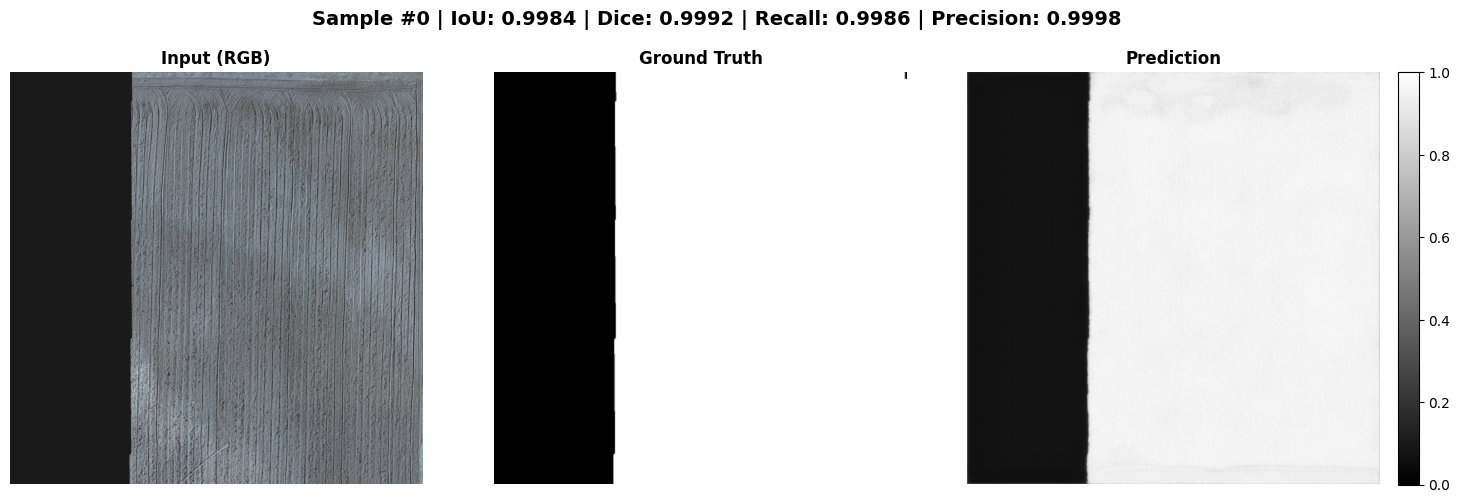

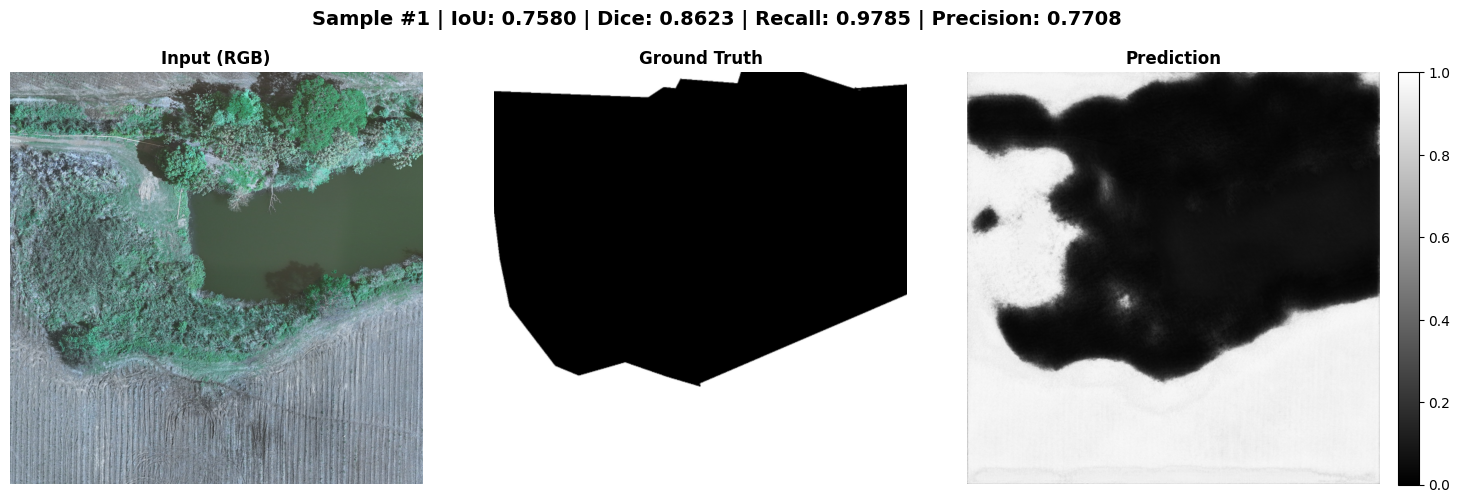

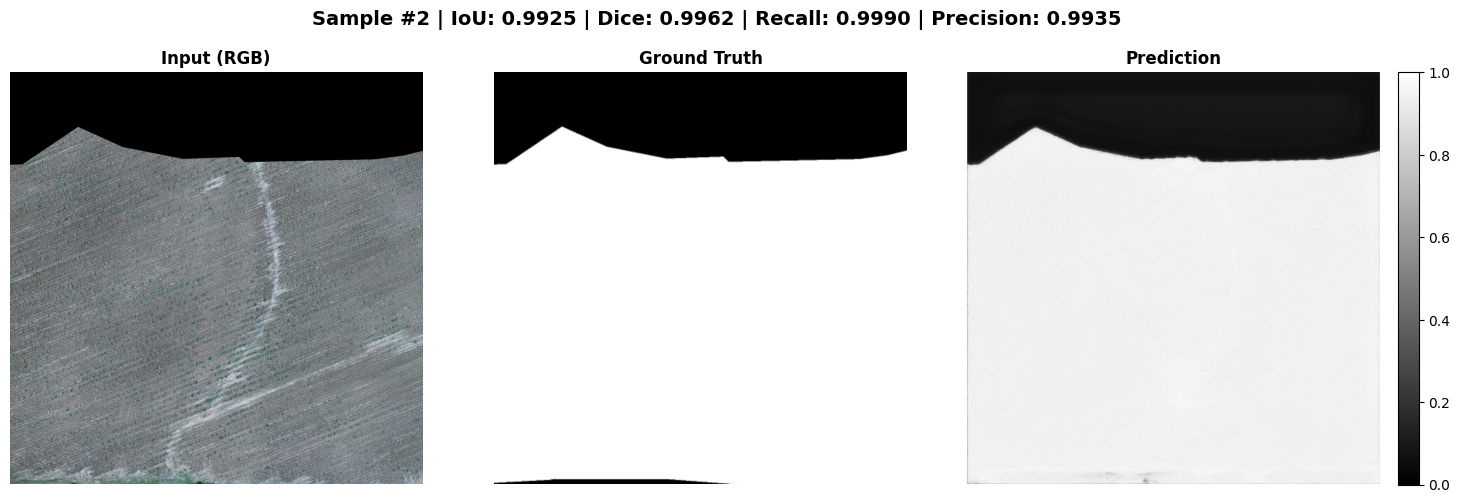

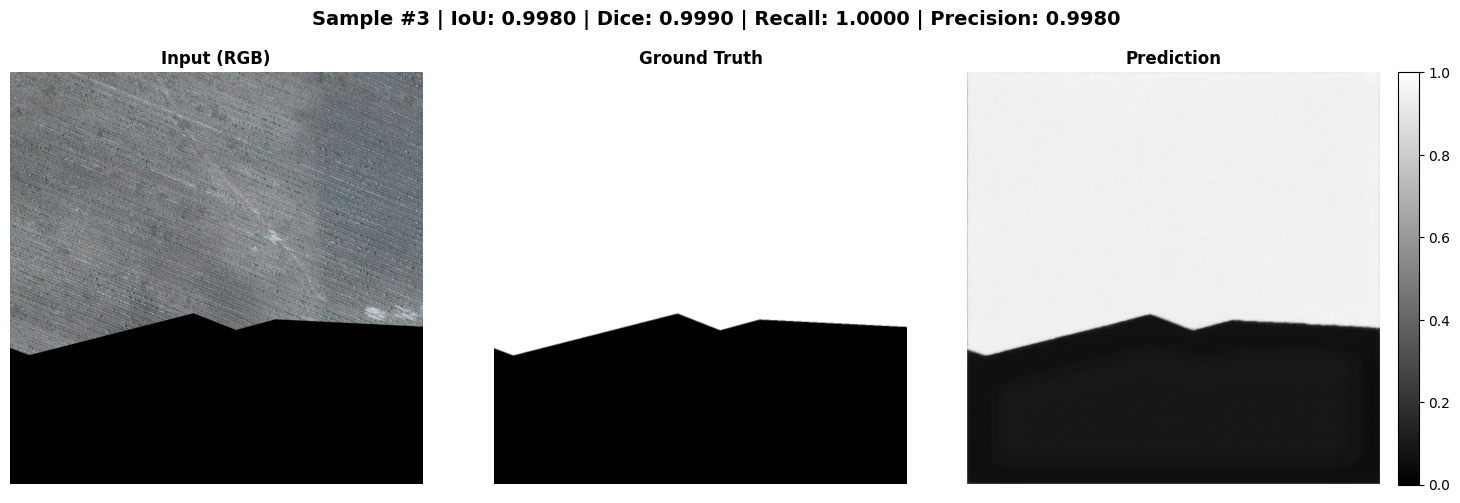

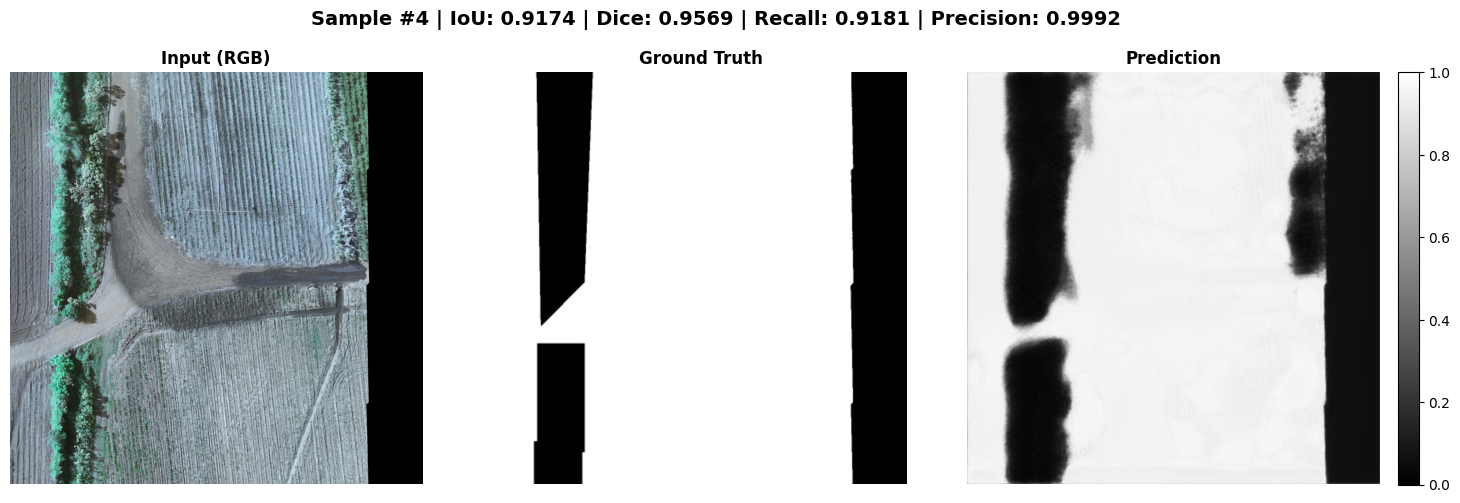

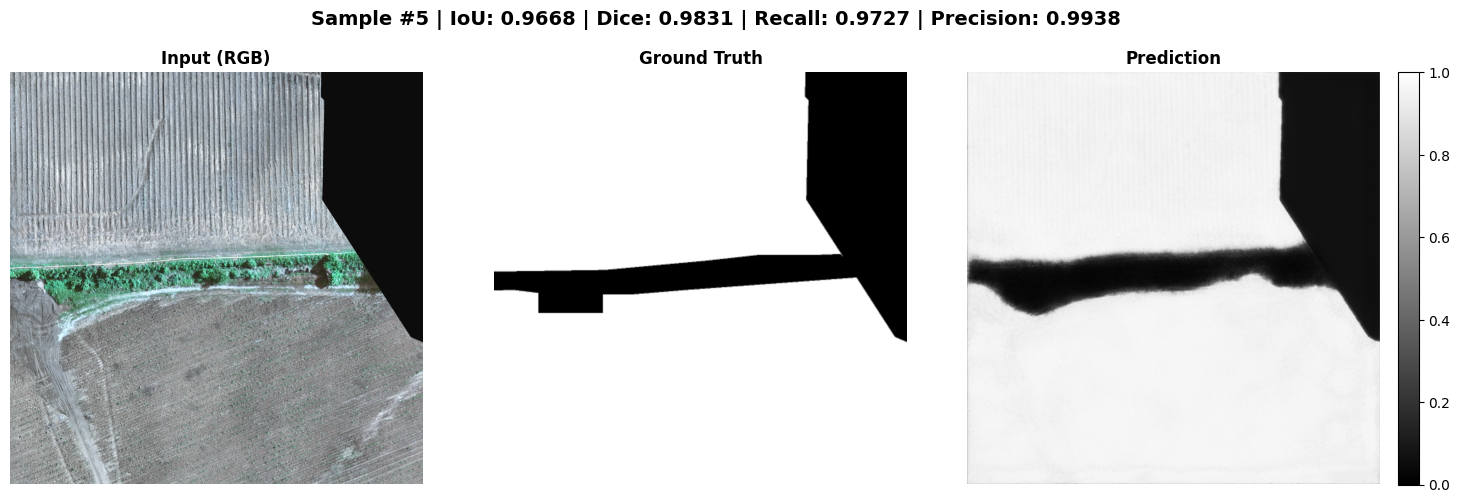

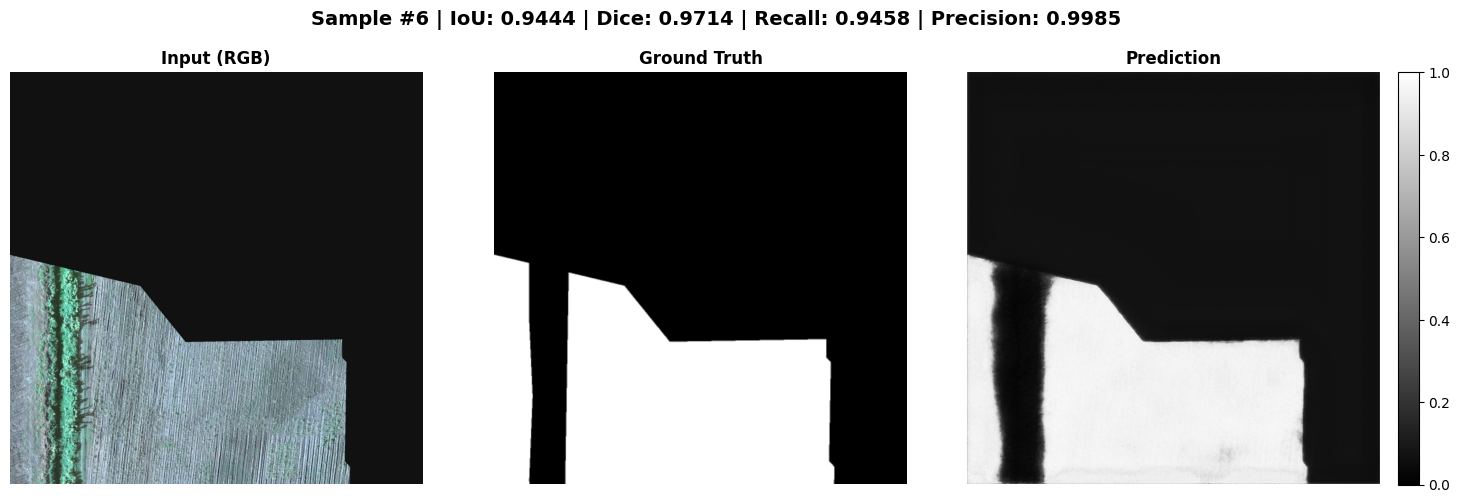

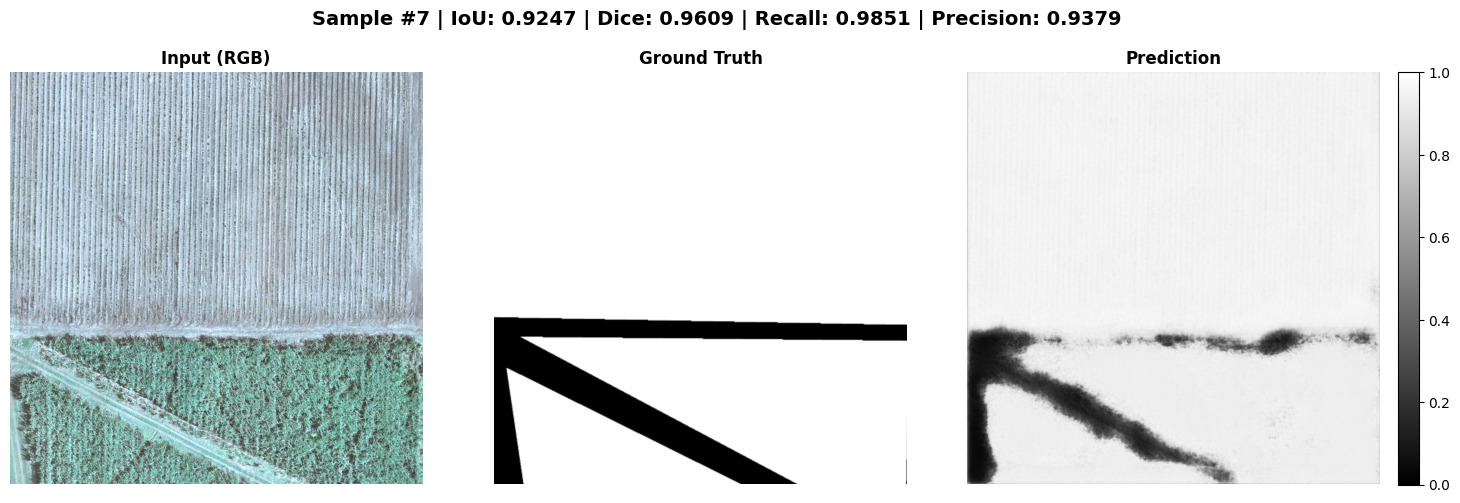

In [ ]:
for i in range(8):
    plot_prediction(trained_model, final_val_loader, device, sample_idx=i)